# DEMO: Data Exploration and Feature Engineering

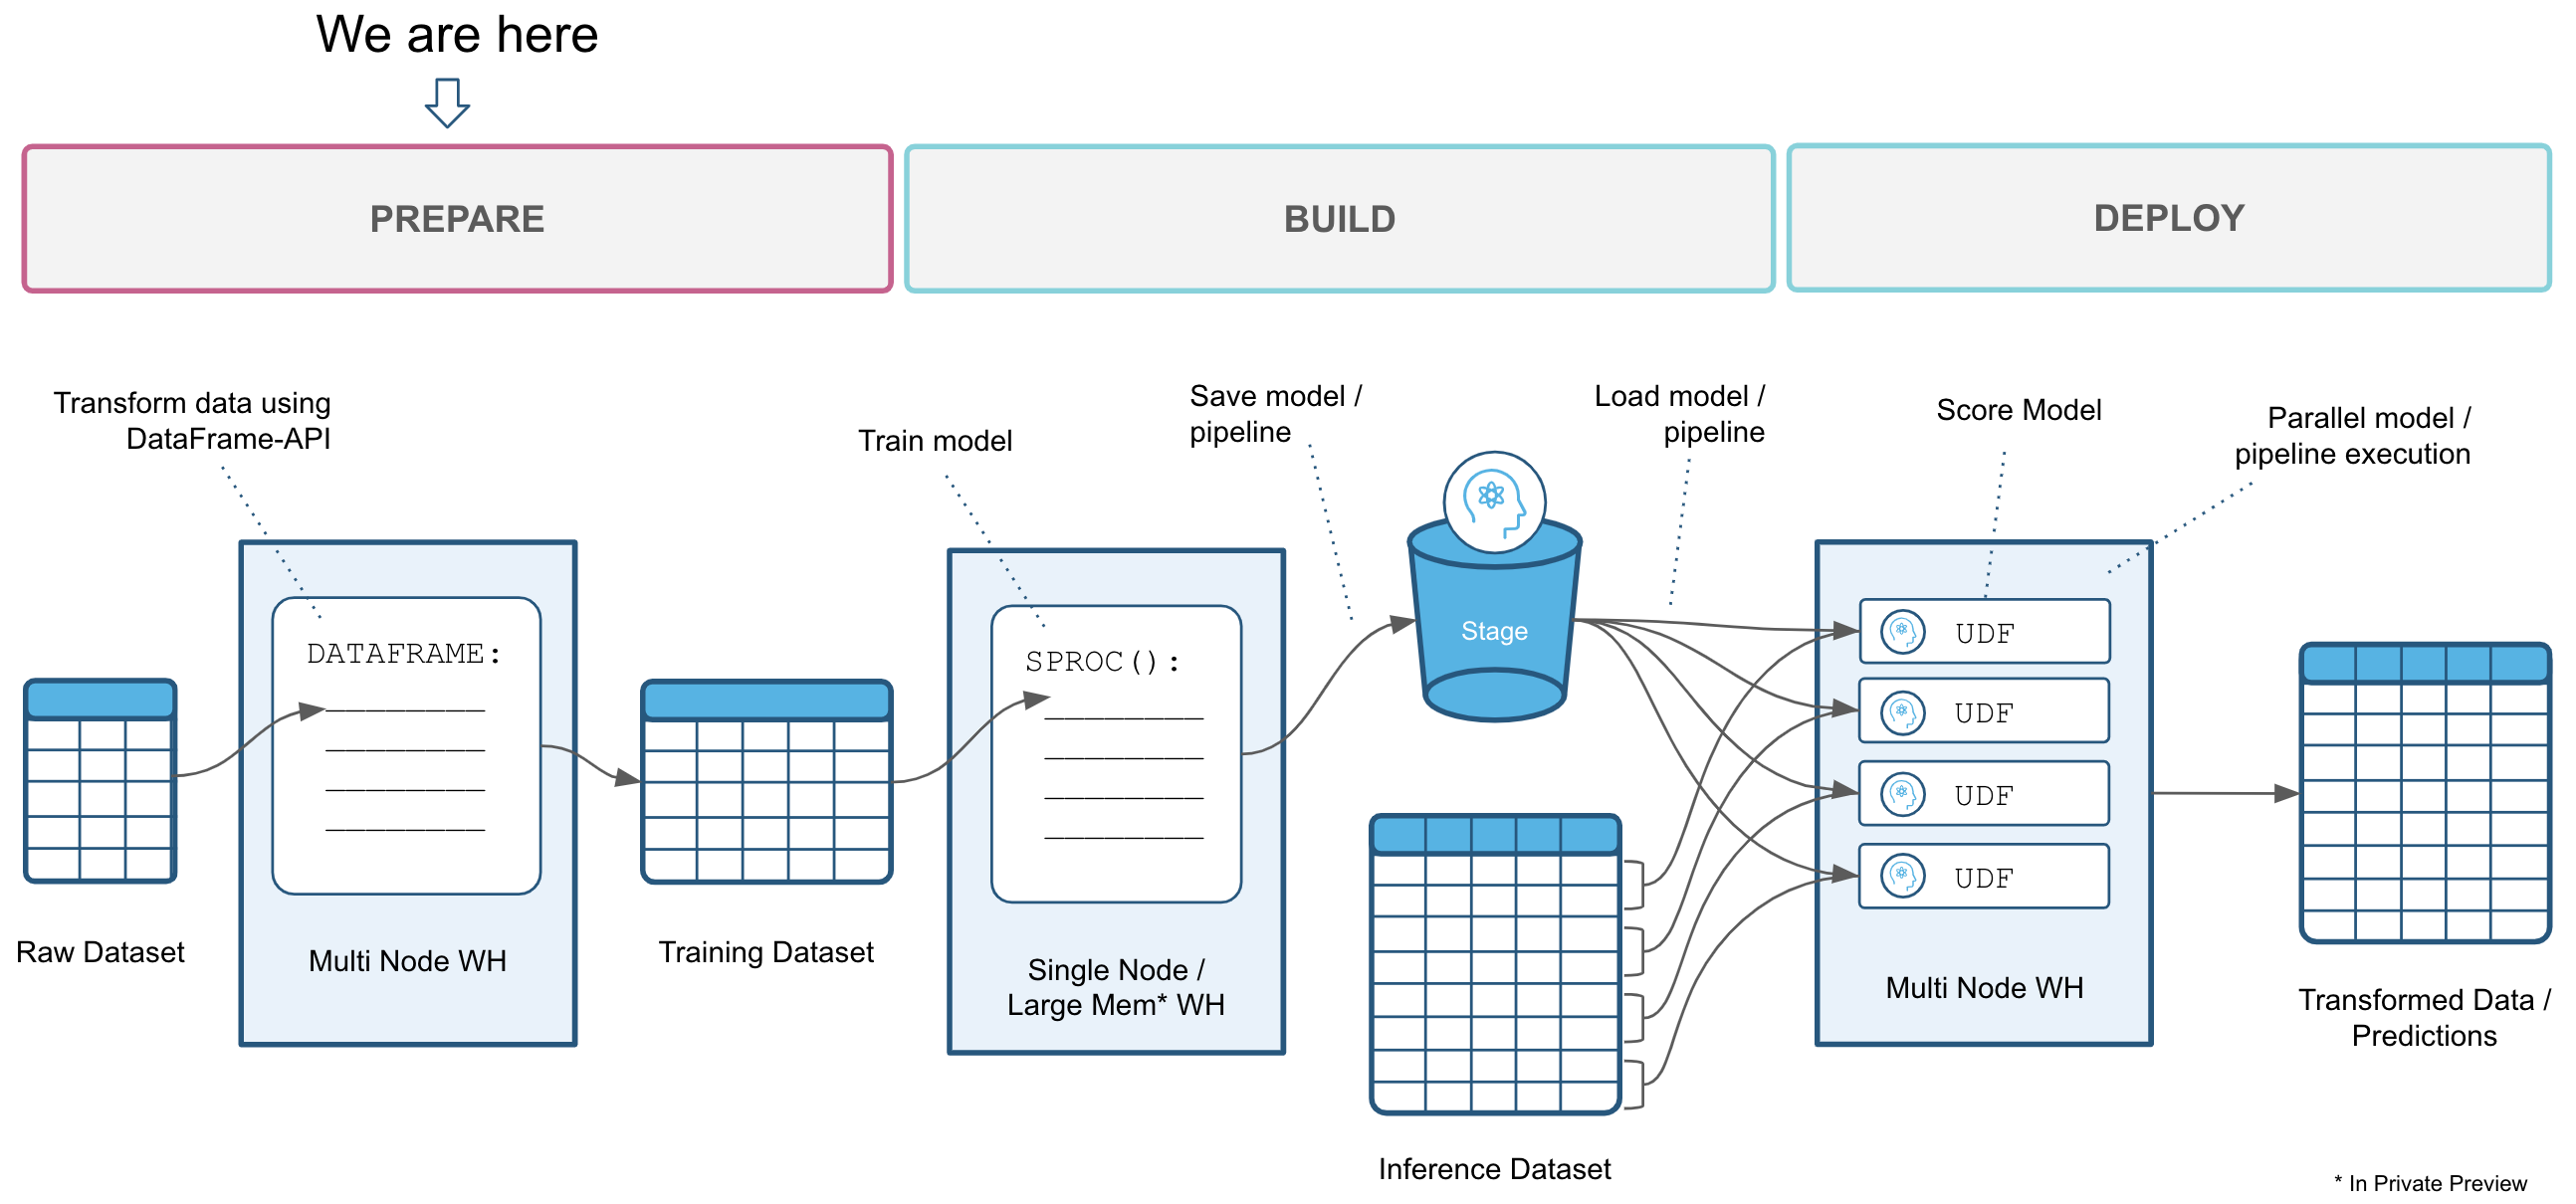

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities

import getpass
import pandas as pd
import matplotlib.pyplot as plt

## Create Snowpark Session

In [2]:
accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

········


In [3]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

········


In [4]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

········


In [5]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "HOL_DB",
    "schema": "PUBLIC",
    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

## Explore and Prepare Data

In [6]:
# Creating a Snowpark DataFrame
application_record_sdf = session.table('APPLICATION_RECORD')
credit_record_sdf = session.table('CREDIT_RECORD')

In [7]:
# How many records do we have?
application_record_sdf.count()

438557

### Duplicate Removal

In [8]:
# Check for duplicate records
duplicates_sdf = application_record_sdf.group_by('ID').agg(F.count(('ID'))).filter(F.col('COUNT(ID)') > 1)
print('Number Duplicates:', duplicates_sdf.count())

Number Duplicates: 47


In [9]:
# Lets drop duplicates
application_record_sdf = application_record_sdf.drop_duplicates('ID')
application_record_sdf.count()

438510

### Simple Statistics

In [10]:
# Obtaining simple statistics per column - why are some statistics missing?
# Can you already identify problems in our data?
# Hint: ID variables are useless for ML models (but we need it for joining)
# Hint: Missing values for OCCUPATION_TYPE
# Hint: Max Value for DAYS_EMPLOYED seems wrong
application_record_sdf.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
1,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,304317,438510.000000
2,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
3,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


### Missing Value Imputation

In [11]:
# We found missing values in OCCUPATION_TYPE - let's impute them
application_record_sdf = application_record_sdf.fillna(value='OTHER', subset=['OCCUPATION_TYPE'])
application_record_sdf.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,438510,438510.000000
1,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
2,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
3,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


### Finding constant variables

In [12]:
# How many distinct values do we have per column?
# Hint: Constant values are probably irrelevant
# Hint: Variables with many different values can be problematic
unique_values = []
for column in application_record_sdf.columns:
    unique_values.append([column, application_record_sdf.select(column).distinct().count()])
pd.DataFrame(unique_values, columns=['COLUMN_NAME','NUM_UNIQUE_VALUES'])

,COLUMN_NAME,NUM_UNIQUE_VALUES
0,ID,438510
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,CNT_CHILDREN,12
5,AMT_INCOME_TOTAL,866
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5
8,NAME_FAMILY_STATUS,5
9,NAME_HOUSING_TYPE,6


In [13]:
# We found FLAG_MOBIL to be constant, lets drop it
application_record_sdf = application_record_sdf.drop('FLAG_MOBIL')

In [14]:
credit_record_sdf.describe().to_pandas()

,SUMMARY,ID,MONTHS_BALANCE,STATUS
0,count,1.048575e+06,1.048575e+06,1048575
1,mean,5.068286e+06,-1.913700e+01,None
2,stddev,4.615058e+04,1.402350e+01,None
3,min,5.001711e+06,-6.000000e+01,0
4,max,5.150487e+06,0.000000e+00,X


### Response Variable (Target)

Explanation of Status Variable:<br>
0: 1-29 days past due<br>
1: 30-59 days past due<br>
2: 60-89 days overdue<br>
3: 90-119 days overdue<br>
4: 120-149 days overdue<br>
5: Overdue or bad debts, write-offs for more than 150 days<br>
C: paid off that month<br>
X: No loan for the month<br>

We will flag credit customers high-risk (1), if during any month they are late on payments by 60 days or more.<br>
All other customers are low-risk (0).

In [15]:
credit_record_sdf.group_by('STATUS').count().sort('STATUS').to_pandas()

,STATUS,COUNT
0,0,383120
1,1,11090
2,2,868
3,3,320
4,4,223
5,5,1693
6,C,442031
7,X,209230


In [16]:
credit_record_sdf = credit_record_sdf.with_column('TARGET', 
                                                  F.when((F.col('STATUS') == '2') | 
                                                         (F.col('STATUS') == '3') | 
                                                         (F.col('STATUS') == '4') | 
                                                         (F.col('STATUS') == '5'), 'YES'))

In [17]:
cpunt = credit_record_sdf.group_by('ID').agg(F.count('TARGET').as_('TARGET'))
cpunt = cpunt.with_column('TARGET', F.when(F.col('TARGET') > 0, 1).otherwise(0))
cpunt = cpunt.drop('DEP_VALUE')

In [18]:
# Target Variable Distribution
# Hint: Highly imbalanced target variables can be problematic
cpunt.group_by('TARGET').agg(F.count('TARGET')).to_pandas()

,TARGET,COUNT(TARGET)
0,0,45318
1,1,667


In [19]:
# Joining our target variable to our customer records
application_record_sdf = application_record_sdf.join(cpunt, using_columns='ID', join_type='inner')
# Finally we can drop the ID variable as we won't use it for training
application_record_sdf = application_record_sdf.drop('ID')
application_record_sdf.count()

36457

## Feature Engineering
For many ML algorithms we need numeric data, so we'll encode our variables.<br>
Sometimes this requires simple replacement, but sometimes we also need other techniques like buckets.<br>

## Binary Variables

### Gender

In [20]:
# High Risk Ratio for CODE_GENDER
var_analysis = application_record_sdf.group_by('CODE_GENDER')
var_analysis = var_analysis.agg([F.count('CODE_GENDER').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis = var_analysis.with_column('HIGH_RISK_RATIO', F.col('HIGH_RISK') / F.col('COUNT'))
var_analysis.sort('CODE_GENDER').to_pandas()

,CODE_GENDER,COUNT,HIGH_RISK,HIGH_RISK_RATIO
0,F,24430,379,0.015514
1,M,12027,237,0.019706


In [21]:
# Encoding M/F to 0/1
application_record_sdf = application_record_sdf.with_column('CODE_GENDER', 
                                                            F.iff(F.col('CODE_GENDER') == 'F', 0, 1))

### Car

In [22]:
# High Risk Ratio for FLAG_OWN_CAR
var_analysis = application_record_sdf.group_by('FLAG_OWN_CAR')
var_analysis = var_analysis.agg([F.count('FLAG_OWN_CAR').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis = var_analysis.with_column('HIGH_RISK_RATIO', F.col('HIGH_RISK') / F.col('COUNT'))
var_analysis.sort('FLAG_OWN_CAR').to_pandas()

,FLAG_OWN_CAR,COUNT,HIGH_RISK,HIGH_RISK_RATIO
0,N,22614,392,0.017334
1,Y,13843,224,0.016181


In [23]:
# Encoding N/Y to 0/1
application_record_sdf = application_record_sdf.with_column('FLAG_OWN_CAR', 
                                                            F.iff(F.col('FLAG_OWN_CAR') == 'N', 0, 1))

### Realty

In [24]:
# High Risk Ratio for FLAG_OWN_CAR
var_analysis = application_record_sdf.group_by('FLAG_OWN_REALTY')
var_analysis = var_analysis.agg([F.count('FLAG_OWN_REALTY').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis = var_analysis.with_column('HIGH_RISK_RATIO', F.col('HIGH_RISK') / F.col('COUNT'))
var_analysis.sort('FLAG_OWN_REALTY').to_pandas()

,FLAG_OWN_REALTY,COUNT,HIGH_RISK,HIGH_RISK_RATIO
0,N,11951,251,0.021002
1,Y,24506,365,0.014894


In [25]:
# Encoding N/Y to 0/1
application_record_sdf = application_record_sdf.with_column('FLAG_OWN_REALTY', 
                                                            F.iff(F.col('FLAG_OWN_REALTY') == 'N', 0, 1))

## Continious Variables

### Children

In [26]:
# High Risk Ratio for CNT_CHILDREN
var_analysis = application_record_sdf.group_by('CNT_CHILDREN')
var_analysis = var_analysis.agg([F.count('CNT_CHILDREN').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis = var_analysis.with_column('HIGH_RISK_RATIO', F.col('HIGH_RISK') / F.col('COUNT'))
var_analysis.sort('CNT_CHILDREN').to_pandas()

,CNT_CHILDREN,COUNT,HIGH_RISK,HIGH_RISK_RATIO
0,0,25201,431,0.017102
1,1,7492,120,0.016017
2,2,3256,52,0.015971
3,3,419,12,0.028640
4,4,63,1,0.015873
5,5,20,0,0.000000
6,7,2,0,0.000000
7,14,3,0,0.000000
8,19,1,0,0.000000


### One-Hot-Encoding
Machine Learning algorithms usually need numeric data.<br>
After creating buckets, we will have to encode them.

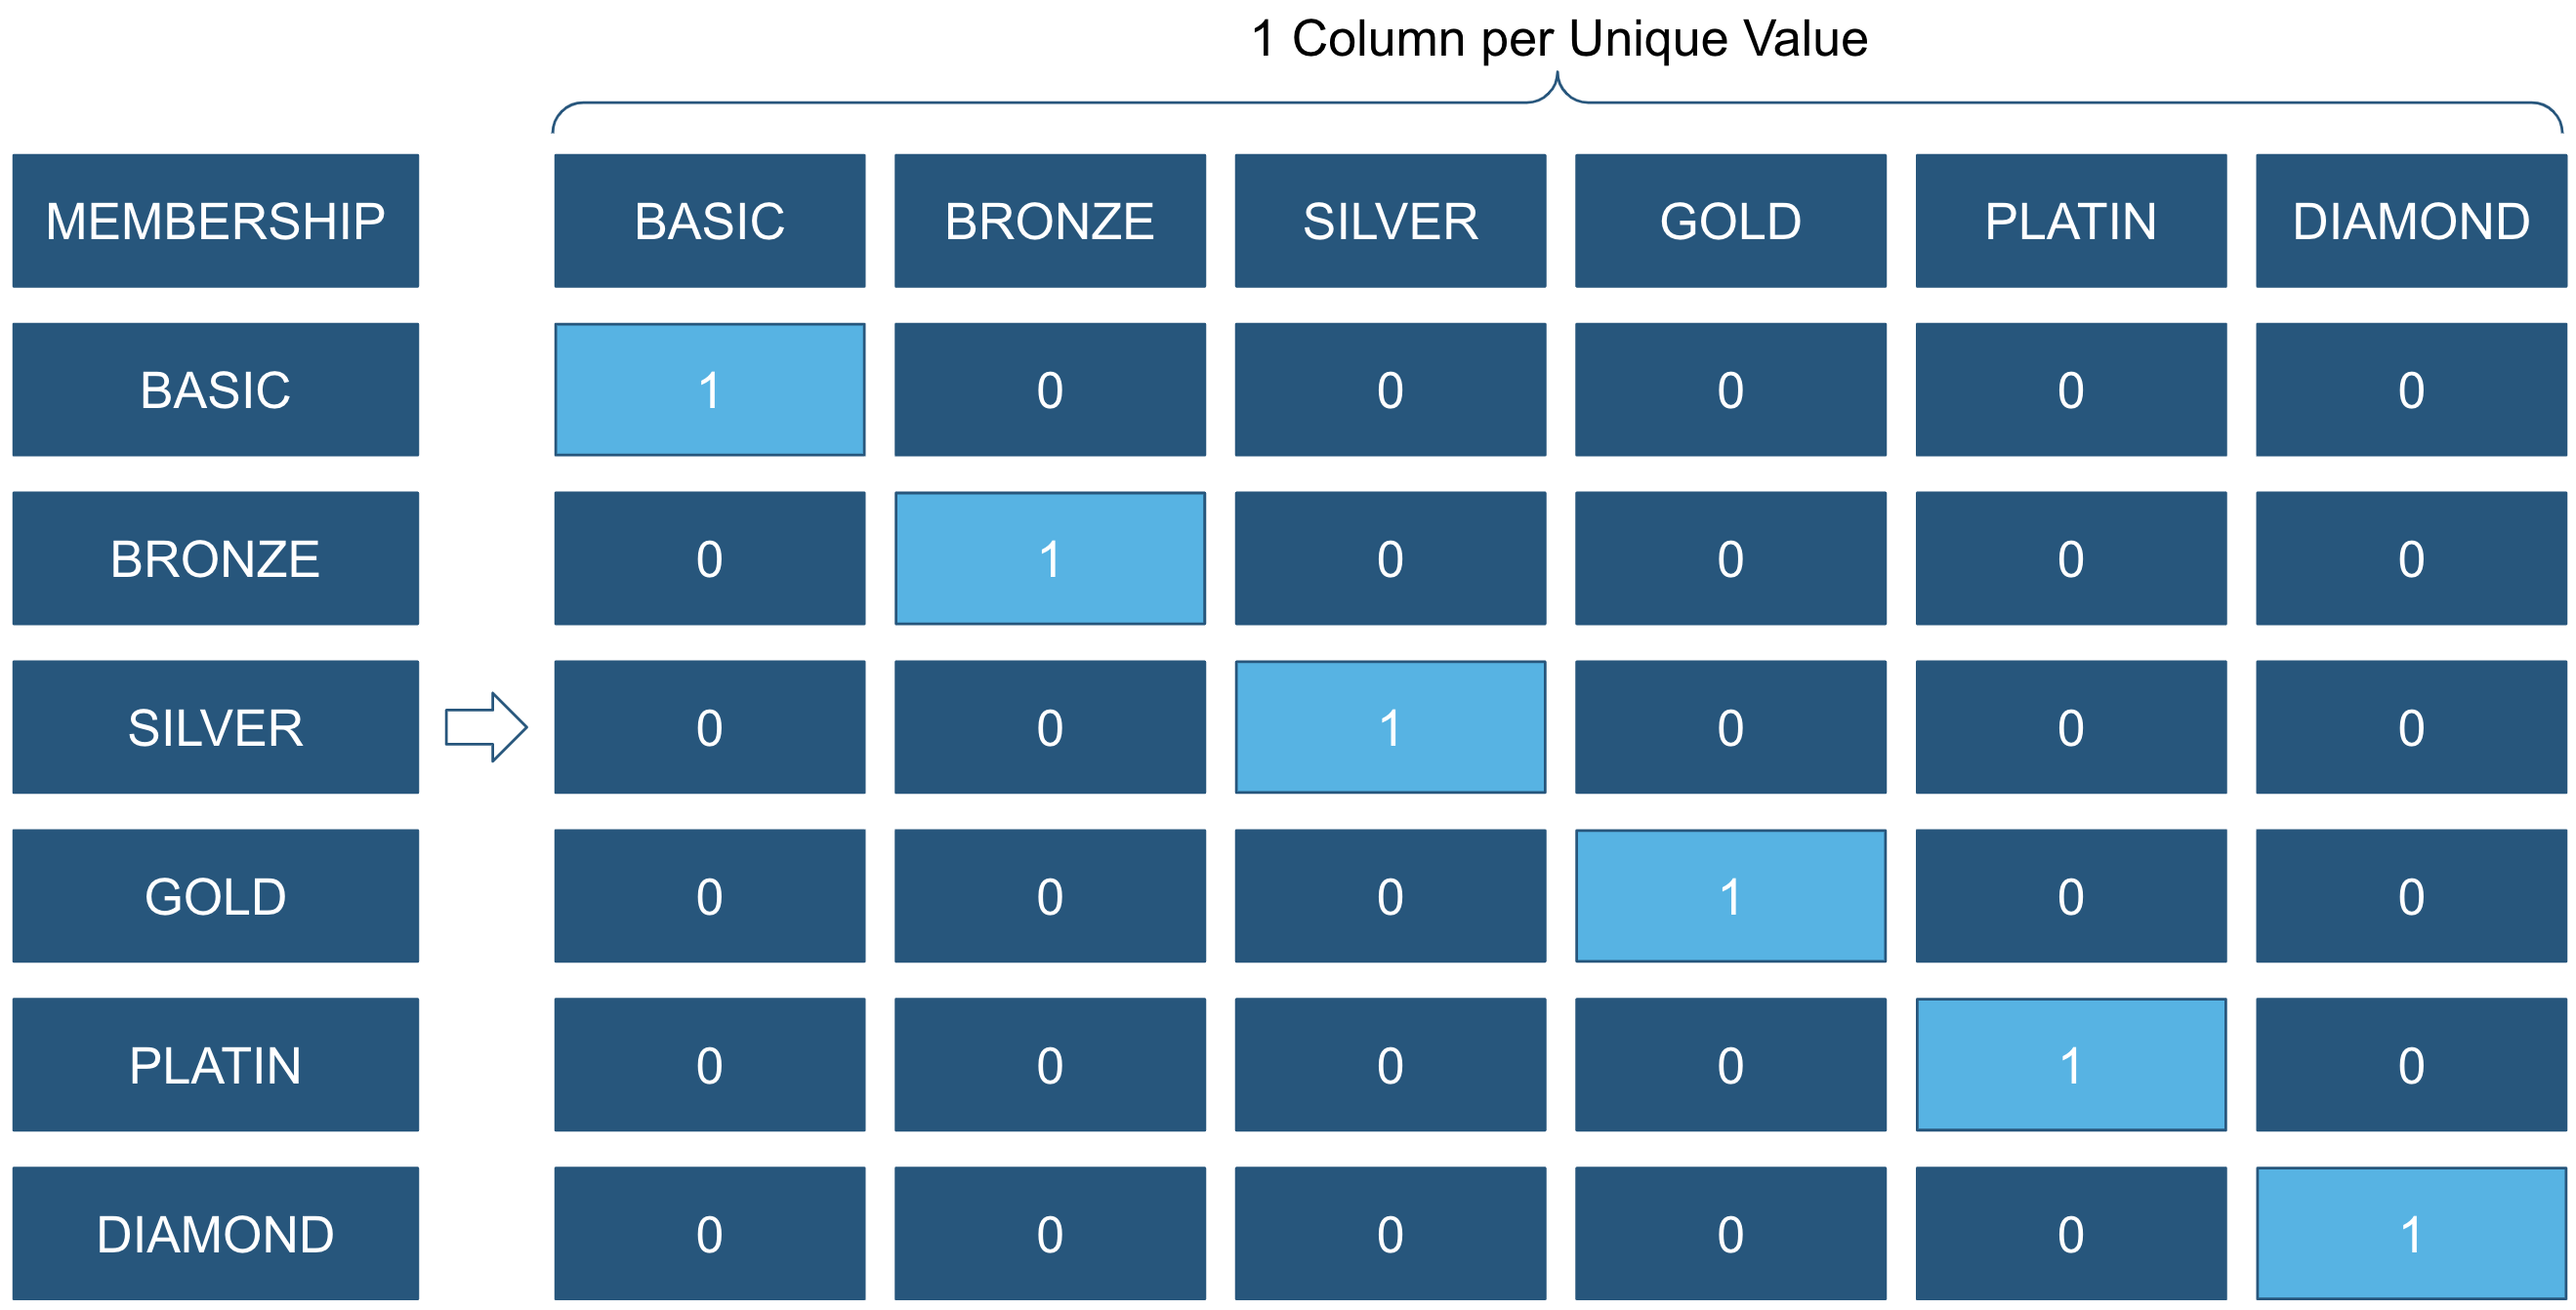

In [27]:
# Creating a new variable CNT_CHILDREN_IND with values 0, 1 or 2More
application_record_sdf = application_record_sdf.with_column('CNT_CHILDREN_IND', 
                                                            F.iff(F.col('CNT_CHILDREN') >= 2, 
                                                                  '2More', 
                                                                  F.to_varchar(F.col('CNT_CHILDREN'))
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('CNT_CHILDREN')

# One-Hot-Encoding of our new indicator-variable
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['CNT_CHILDREN_IND'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

#application_record_sdf = application_record_sdf.drop('CNT_CHILDREN_IND_0')

### Income

In [28]:
# Custom-Function to create n equal-sized bucket
def bucketize(df, column, labels=[]):
    window = Window().order_by(column)
    _temp = df.with_column('BUCKET', F.ntile(F.lit(len(labels))).over(window))
    _temp = _temp.group_by('BUCKET').agg([F.min(column).as_('MIN'), F.max(column).as_('MAX')]).to_pandas()
    condition = F.iff(F.col(column) > float(_temp.iloc[1].MIN), labels[1], labels[0])
    for ix, row in _temp[2:].iterrows():
        condition = F.iff(F.col(column) > float(row.MIN), labels[ix], condition)
    df = df.with_column(column + '_BUCKET', condition)
    return df

In [29]:
# Bucketize AMT_INCOME_TOTAL
application_record_sdf = application_record_sdf.with_column('AMT_INCOME_TOTAL', F.col('AMT_INCOME_TOTAL') / 10000)
application_record_sdf = bucketize(application_record_sdf, 'AMT_INCOME_TOTAL', labels=['LOW','MEDIUM','HIGH'])

In [30]:
# High Risk Ratio for AMT_INCOME_TOTAL_BUCKET
var_analysis = application_record_sdf.group_by('AMT_INCOME_TOTAL_BUCKET')
var_analysis = var_analysis.agg([F.count('AMT_INCOME_TOTAL_BUCKET').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis = var_analysis.with_column('HIGH_RISK_RATIO', F.col('HIGH_RISK') / F.col('COUNT'))
var_analysis.sort('AMT_INCOME_TOTAL_BUCKET').to_pandas()

,AMT_INCOME_TOTAL_BUCKET,COUNT,HIGH_RISK,HIGH_RISK_RATIO
0,HIGH,11282,194,0.017196
1,LOW,14473,257,0.017757
2,MEDIUM,10702,165,0.015418


In [31]:
# One-Hot-Encoding of our new bucket-variable
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['AMT_INCOME_TOTAL_BUCKET'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### Age
The age variable is very cryptic and hard to interpret.<br>
Let's calculate the customer age in years.<br>

Explanation of DAYS_BIRTH Variable:<br>
Counts backwards from current day (0), -1 means yesterday

In [32]:
# Calculate the age given the number of days
application_record_sdf = application_record_sdf.with_column('AGE', F.abs(F.floor(F.col('DAYS_BIRTH') / 365)))
application_record_sdf = application_record_sdf.drop('DAYS_BIRTH')

<AxesSubplot: title={'center': 'High Risk Ratio per Age'}, xlabel='AGE'>

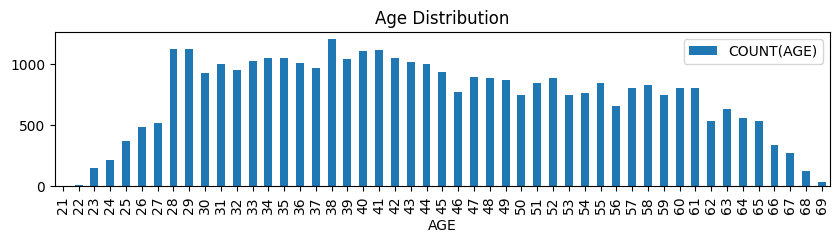

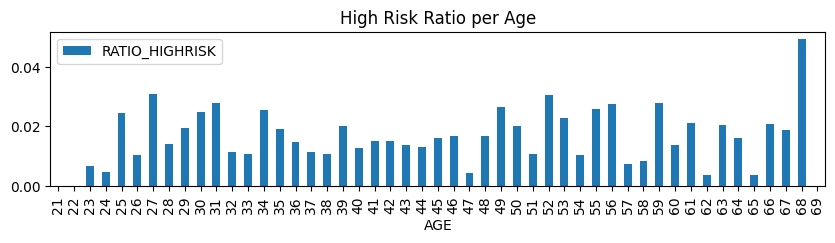

In [33]:
# Age Distribution
grouped_ages_df = application_record_sdf.group_by('AGE').agg(F.count('AGE')).sort('AGE')
grouped_ages_df.to_pandas().plot.bar(x='AGE', y='COUNT(AGE)', figsize=(10,2), title='Age Distribution')
# High Risk Ratio per age
grouped_ages_df = application_record_sdf.group_by('AGE').agg([F.count('AGE'),F.sum('TARGET')]).sort('AGE')
grouped_ages_df = grouped_ages_df.with_column('RATIO_HIGHRISK', F.as_double(F.col('SUM(TARGET)') / F.col('COUNT(AGE)')))
grouped_ages_df.to_pandas().plot.bar(x='AGE', y='RATIO_HIGHRISK', figsize=(10,2), title='High Risk Ratio per Age')

In [34]:
# This time, we'll bucketize the variable by hand
application_record_sdf = application_record_sdf.with_column('AGE_BUCKET', 
                                                            F.iff(F.col('AGE') < 30, 'LOWEST', 
                                                                  F.iff(F.col('AGE') < 40, 'LOW', 
                                                                       F.iff(F.col('AGE') < 50, 'MEDIUM', 
                                                                            F.iff(F.col('AGE') < 60, 'HIGH', 'HIGHEST')
                                                                            )
                                                                       )
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('AGE')

# One-Hot-Encoding of our new bucket-variable
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['AGE_BUCKET'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### Working Years
We can apply the same logic for the years of employment.<br>
Remember: Some records indicate wrong values (too high)<br>

<AxesSubplot: xlabel='WORKYEARS'>

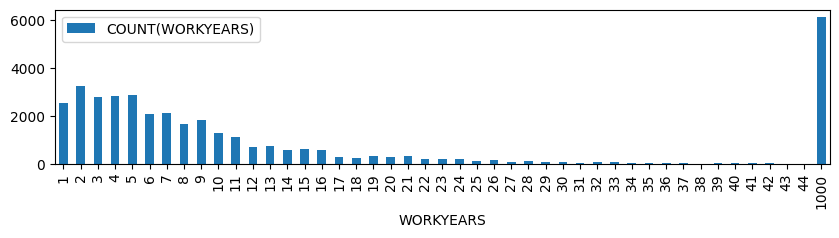

In [35]:
# Calculate the workyears given the number of days of employment
application_record_sdf = application_record_sdf.with_column('WORKYEARS', F.abs(F.floor(F.col('DAYS_EMPLOYED') / 365)))
application_record_sdf = application_record_sdf.drop('DAYS_EMPLOYED')
grouped_workyears_df = application_record_sdf.group_by('WORKYEARS').agg(F.count('WORKYEARS')).sort('WORKYEARS').to_pandas()
grouped_workyears_df.plot.bar(x='WORKYEARS', figsize=(10,2))

In [36]:
# Lets filter out people with 1000 years of employment ...
application_record_sdf = application_record_sdf.filter(F.col('WORKYEARS') < 50)

In [37]:
# This time, we'll bucketize the variable by hand
application_record_sdf = application_record_sdf.with_column('WORKYEAR_BUCKET', 
                                                            F.iff(F.col('WORKYEARS') < 10, 'LOW', 
                                                                  F.iff(F.col('WORKYEARS') < 20, 'LOWEST', 
                                                                       F.iff(F.col('WORKYEARS') < 30, 'MEDIUM', 
                                                                            F.iff(F.col('WORKYEARS') < 40, 'HIGH', 'HIGHEST')
                                                                            )
                                                                       )
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('WORKYEARS')

# One-Hot-Encoding of our new bucket-variable
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['WORKYEAR_BUCKET'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### Family Size

In [38]:
# High Risk Ratio for CNT_FAM_MEMBERS
var_analysis = application_record_sdf.group_by('CNT_FAM_MEMBERS')
var_analysis = var_analysis.agg([F.count('CNT_FAM_MEMBERS').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis = var_analysis.with_column('HIGH_RISK_RATIO', F.col('HIGH_RISK') / F.col('COUNT'))
var_analysis.sort('CNT_FAM_MEMBERS').to_pandas()

,CNT_FAM_MEMBERS,COUNT,HIGH_RISK,HIGH_RISK_RATIO
0,1.0,5151,92,0.017861
1,2.0,15389,251,0.016310
2,3.0,6255,101,0.016147
3,4.0,3057,46,0.015047
4,5.0,387,12,0.031008
5,6.0,58,1,0.017241
6,7.0,19,0,0.000000
7,9.0,2,0,0.000000
8,15.0,3,0,0.000000
9,20.0,1,0,0.000000


In [39]:
# Creating a new variable CNT_FAM_MEMBERS_IND with values 0, 1, 2 or 3More
application_record_sdf = application_record_sdf.with_column('CNT_FAM_MEMBERS_IND', 
                                                            F.iff(F.col('CNT_FAM_MEMBERS') >= 3, 
                                                                  '3More', 
                                                                  F.to_varchar(F.col('CNT_FAM_MEMBERS'))
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('CNT_FAM_MEMBERS')

# One-Hot-Encoding of our new indicator-variable
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['CNT_FAM_MEMBERS_IND'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

## Categorical Variables

### Income Type

<AxesSubplot: ylabel='NAME_INCOME_TYPE'>

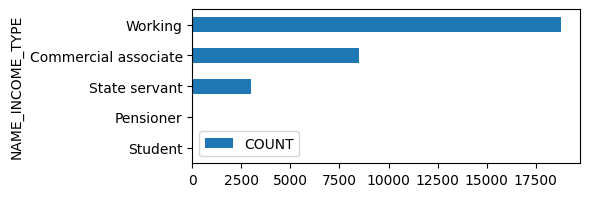

In [40]:
# Distribution of income types
var_analysis = application_record_sdf.group_by('NAME_INCOME_TYPE').agg(F.count('NAME_INCOME_TYPE').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').to_pandas()
var_analysis.plot.barh(x='NAME_INCOME_TYPE', figsize=(5,2))

In [41]:
# Let's remove students and pensioners
jobs = ['Working', 'Commercial associate', 'State servant']
application_record_sdf = application_record_sdf.filter(F.col('NAME_INCOME_TYPE').in_(jobs))

In [42]:
# Clean the values before OHE
application_record_sdf = application_record_sdf.with_column('NAME_INCOME_TYPE', 
                                                            F.upper(
                                                                F.regexp_replace('NAME_INCOME_TYPE', '[^a-zA-Z0-9]+', '_'))
                                                           )

In [43]:
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['NAME_INCOME_TYPE'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### Occupation

<AxesSubplot: ylabel='OCCUPATION_TYPE'>

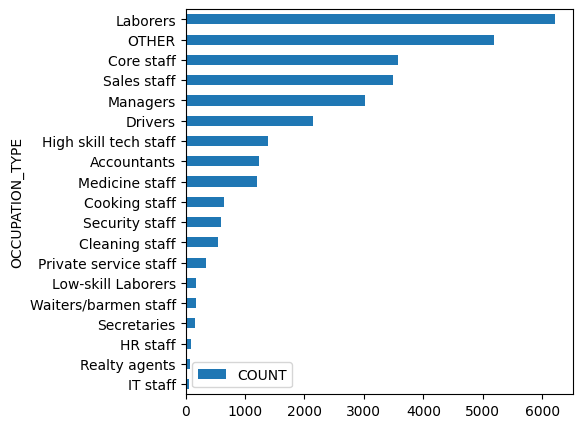

In [44]:
# Distribution of income types
var_analysis = application_record_sdf.group_by('OCCUPATION_TYPE').agg(F.count('OCCUPATION_TYPE').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').to_pandas()
var_analysis.plot.barh(x='OCCUPATION_TYPE', figsize=(5,5))

In [45]:
# Occupation Type
labour_work = ['Cleaning staff', 
               'Cooking staff', 
               'Drivers', 
               'Laborers', 
               'Low-skill Laborers', 
               'Security staff', 
               'Waiters/barmen staff']

office_work = ['Accountants', 
               'Core staff', 
               'HR staff', 
               'Medicine staff', 
               'Private service staff', 
               'Realty agents', 
               'Sales staff', 
               'Secretaries']

hightech_work = ['Managers', 
                 'High skill tech staff', 
                 'IT staff']

application_record_sdf = application_record_sdf.with_column('OCCUPATION_TYPE', 
                                                            F.iff(F.col('OCCUPATION_TYPE').in_(labour_work), 'LABOURWORK', 
                                                                 F.iff(F.col('OCCUPATION_TYPE').in_(office_work), 'OFFICEWORK', 
                                                                      F.iff(F.col('OCCUPATION_TYPE').in_(hightech_work), 'HIGHTECHWORK', 'OTHER')
                                                                      )
                                                                 )
                                                           )

In [46]:
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['OCCUPATION_TYPE'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### House Type

<AxesSubplot: ylabel='NAME_HOUSING_TYPE'>

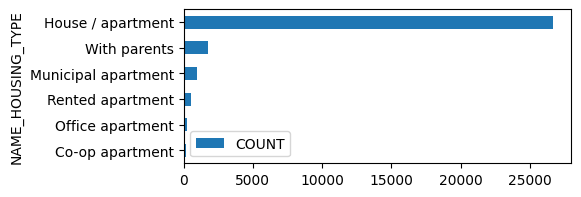

In [47]:
# Distribution of house types
var_analysis = application_record_sdf.group_by('NAME_HOUSING_TYPE').agg(F.count('NAME_HOUSING_TYPE').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').to_pandas()
var_analysis.plot.barh(x='NAME_HOUSING_TYPE', figsize=(5,2))

In [48]:
# Clean the values before OHE
application_record_sdf = application_record_sdf.with_column('NAME_HOUSING_TYPE', 
                                                            F.upper(
                                                                F.regexp_replace('NAME_HOUSING_TYPE', '[^a-zA-Z0-9]+', '_'))
                                                           )

In [49]:
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['NAME_HOUSING_TYPE'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### Education

<AxesSubplot: ylabel='NAME_EDUCATION_TYPE'>

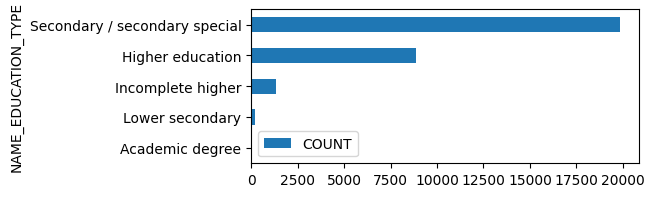

In [50]:
# Distribution of education types
var_analysis = application_record_sdf.group_by('NAME_EDUCATION_TYPE').agg(F.count('NAME_EDUCATION_TYPE').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').to_pandas()
var_analysis.plot.barh(x='NAME_EDUCATION_TYPE', figsize=(5,2))

In [51]:
# Add small number of academics to higher education 
application_record_sdf = application_record_sdf.with_column('NAME_EDUCATION_TYPE', 
                                                            F.replace(F.col('NAME_EDUCATION_TYPE'), 
                                                                      'Academic degree', 
                                                                      'Higher education'))

# Clean the values before OHE
application_record_sdf = application_record_sdf.with_column('NAME_EDUCATION_TYPE', 
                                                            F.upper(
                                                                F.regexp_replace('NAME_EDUCATION_TYPE', '[^a-zA-Z0-9]+', '_'))
                                                           )

# One-Hot-Encoding
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['NAME_EDUCATION_TYPE'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

### Family Status

<AxesSubplot: ylabel='NAME_FAMILY_STATUS'>

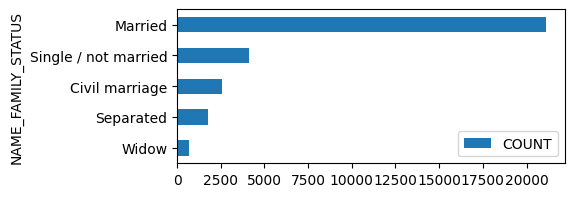

In [52]:
# Distribution of family status types
var_analysis = application_record_sdf.group_by('NAME_FAMILY_STATUS').agg(F.count('NAME_FAMILY_STATUS').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').to_pandas()
var_analysis.plot.barh(x='NAME_FAMILY_STATUS', figsize=(5,2))

In [53]:
# Clean the values before OHE
application_record_sdf = application_record_sdf.with_column('NAME_FAMILY_STATUS', 
                                                            F.upper(
                                                                F.regexp_replace('NAME_FAMILY_STATUS', '[^a-zA-Z0-9]+', '_'))
                                                           )

# One-Hot-Encoding
one_hot_encoder = preprocessing.OneHotEncoder(input_cols=['NAME_FAMILY_STATUS'])
one_hot_encoder.fit(application_record_sdf)
application_record_sdf = one_hot_encoder.transform(application_record_sdf)

In [54]:
application_record_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED', mode='overwrite')

# Synthetic Minority Oversampling Technique (SMOTE)
https://github.com/scikit-learn-contrib/imbalanced-learn

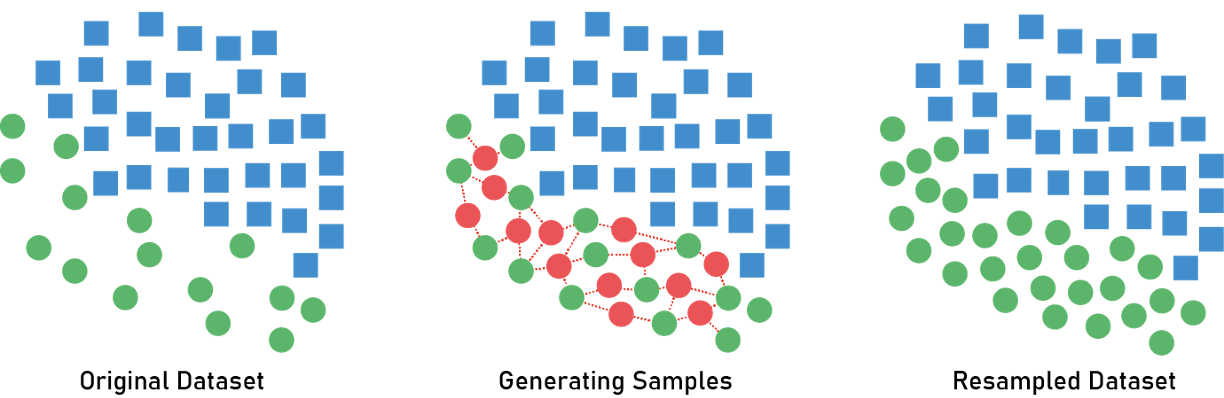

In [55]:
# We have highly imbalanced data
application_record_sdf.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,0,29808
1,1,486


In [56]:
session.sql('CREATE OR REPLACE STAGE ML_PROCS').collect()
pd.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration
0,2022-10-24 08:04:29.596000-07:00,ML_PROCS,HOL_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL,None,None,None


In [57]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake

def sproc_oversample_smote(session: Session, 
                           training_table: str, 
                           feature_cols: list,
                           target_col: str,
                           target_table: str) -> T.Variant:
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]
    
    # Oversample minority class via SMOTE
    from imblearn.over_sampling import SMOTE
    X_balance, y_balance = SMOTE().fit_resample(X,y)
    
    # Combine return values into single pandas dataframe
    X_balance[target_col] = y_balance
    
    # Persist dataframe in Snowflake table
    session.sql('DROP TABLE IF EXISTS {}'.format(target_table)).collect()
    session.write_pandas(X_balance, table_name=target_table, auto_create_table=True)
    
    # Getting model coefficients
    return "Successfully oversampled"

In [58]:
# Get the path of imblearn package
import imblearn
imblearn_path = imblearn.__path__[0]
print(imblearn_path)

/Users/mgorkow/opt/anaconda3/envs/pysnowpark/lib/python3.8/site-packages/imblearn


In [59]:
# Registering the function as a Stored Procedure
sproc_oversample_smote = session.sproc.register(func=sproc_oversample_smote, 
                                                name='sproc_oversample_smote', 
                                                is_permanent=True, 
                                                replace=True,
                                                stage_location='@ML_PROCS',
                                                packages=['snowflake-snowpark-python','scikit-learn==1.1.1'],
                                                imports=[imblearn_path])

In [60]:
training_table = 'CREDIT_RISK_PREPARED'
# get feature columns
feature_cols = application_record_sdf.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'
target_table = 'CREDIT_RISK_PREPARED_BALANCED'

sproc_oversample_smote(training_table, 
                       feature_cols, 
                       target_col,
                       target_table, 
                       session=session)

'"Successfully oversampled"'

In [61]:
# Now our training data is balanced
train_data_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
train_data_sdf.group_by('TARGET').count().to_pandas()

,TARGET,COUNT
0,0,29808
1,1,29808
